In [38]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

## Pembersihan Teks
Membersihkan teks dengan menghapus karakter yang tidak perlu, menghapus stop words, dan melakukan stemming untuk menyederhanakan kata-kata menjadi bentuk dasarnya.

In [39]:
factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()

stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()

In [40]:
def clean_text(text):
    text = re.sub(r'\b(yg)\b', 'yang', text)
    text = re.sub(r'\b(utk)\b', 'untuk', text)
    text = re.sub(r'\b(tdk)\b', 'tidak', text)
    text = re.sub(r'\b(dg)\b', 'dengan', text)
    
    text = re.sub(r'\b(nya)\b', '.', text)  
    text = re.sub(r'\b(lah)\b', '', text)   
    text = re.sub(r'\b(kah)\b', '', text) 
    
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    text = stopword.remove(text)
    text = stemmer.stem(text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

## Pembersihan Data
Membersihkan dan memproses data yang berisi tweet, menyiapkan data tersebut untuk analisis lebih lanjut. Fungsi ini melakukan beberapa operasi penting, termasuk penghapusan kolom yang tidak diperlukan, penanganan nilai kosong, filter berdasarkan bahasa, konversi kolom tanggal ke tipe datetime, dan pembersihan teks.

In [41]:
def clean_df(df):
    df = df.drop(columns=[
        'image_url', 
        'in_reply_to_screen_name', 
        'conversation_id_str', 
        'id_str', 
        'quote_count', 
        'reply_count',  
        'tweet_url', 
        'user_id_str',
        'location'
    ])
    
    df = df.dropna(subset=['created_at', 'lang', 'full_text'])
    
    df = df[df['lang'] == 'in']
    
    datetime_format = '%a %b %d %H:%M:%S %z %Y' 
    df['created_at'] = pd.to_datetime(df['created_at'], format=datetime_format, errors='coerce')
    df['created_at'] = df['created_at'].dt.tz_localize(None)
    

    df['full_text'] = df['full_text'].apply(clean_text)
    
    return df

## Membaca dan Membersihkan Data
Menggabungkan beberapa file CSV yang berisi data tweet dan membersihkannya

In [42]:
input_files = [
    'Datasets/Teks/bansos_bansos.csv', 
    'Datasets/Teks/bansos_jokowi.csv',
    'Datasets/Teks/pemilu_bansos.csv'
]

combined_df = pd.DataFrame()

In [43]:
for input_file in input_files:
    df = pd.read_csv(input_file)
    cleaned_df = clean_df(df)
    combined_df = pd.concat([combined_df, cleaned_df], ignore_index=True)

combined_df.to_csv('Datasets/Teks/data_bansos.csv', index=False)

In [44]:
df = pd.read_csv('Datasets/Teks/data_bansos.csv')

df

,created_at,favorite_count,full_text,lang,retweet_count,username
0,2024-04-23 12:54:22,305,nilai tukar rupiah lemah thp dolar as pd bulan...,in,147,NenkMonica
1,2024-04-22 11:31:10,2135,kami warga nangroe aceh darussalam jakarta pul...,in,630,CutSarina5
2,2024-04-22 23:32:30,2065,good morning rakyat bodoh bani bansos mental b...,in,679,CutSarina5
3,2024-04-16 09:30:03,282,kangen bansos bansos henti milu,in,119,temponewsroom
4,2024-04-22 05:37:12,649,mk minta salur bansos tak laku jelang milu,in,173,tempodotco
...,...,...,...,...,...,...
1039,2024-05-21 00:32:03,0,alah anda malam milu ada operasi bansos ganjar...,in,0,Melvin04061998
1040,2024-05-06 01:47:16,2,memang bansos apa bantu bantu langsung paling ...,in,1,dpwpkbjatim_
1041,2024-05-05 01:14:36,0,milu rame promosi ngabisin duid rakyat wahai k...,in,0,AnnaYellowHeart
1042,2024-05-30 13:43:29,48,habis uang negara ikn bansos milu menang putra...,in,14,aldrovandi10


## Menambahkan Kolom Sentimen Acak
Menambahkan kolom sentimen dengan nilai acak ('positif', 'netral', 'negatif') untuk keperluan eksperimen.

In [45]:
import random
random.seed(42)
df['sentimen'] = random.choices(['positif', 'netral', 'negatif'], k=len(df))

## Membagi Data dan Memodelkan Sentimen
Membagi data menjadi set pelatihan dan pengujian, mengubah teks menjadi fitur TF-IDF, dan melatih model Naive Bayes untuk memprediksi sentimen

In [46]:
X = df['full_text']
y = df['sentimen']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
vectorizer = TfidfVectorizer(max_features=5000)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

model = MultinomialNB()

model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)

In [48]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.3588516746411483
Classification Report:
               precision    recall  f1-score   support

     negatif       0.42      0.44      0.43        80
      netral       0.33      0.31      0.32        58
     positif       0.31      0.31      0.31        71

    accuracy                           0.36       209
   macro avg       0.35      0.35      0.35       209
weighted avg       0.36      0.36      0.36       209



## Menyimpan Prediksi Sentimen
Menambahkan prediksi sentimen ke DataFrame dan menyimpannya ke file CSV.

In [49]:
df['sentiment_predicted'] = model.predict(vectorizer.transform(df['full_text']))

df.to_csv('Datasets/Teks/data_bansos_with_sentiment_predicted.csv', index=False)

df.head()

,created_at,favorite_count,full_text,lang,retweet_count,username,sentimen,sentiment_predicted
0,2024-04-23 12:54:22,305,nilai tukar rupiah lemah thp dolar as pd bulan...,in,147,NenkMonica,netral,netral
1,2024-04-22 11:31:10,2135,kami warga nangroe aceh darussalam jakarta pul...,in,630,CutSarina5,positif,positif
2,2024-04-22 23:32:30,2065,good morning rakyat bodoh bani bansos mental b...,in,679,CutSarina5,positif,positif
3,2024-04-16 09:30:03,282,kangen bansos bansos henti milu,in,119,temponewsroom,positif,netral
4,2024-04-22 05:37:12,649,mk minta salur bansos tak laku jelang milu,in,173,tempodotco,negatif,negatif


## Hasil Visualisasi

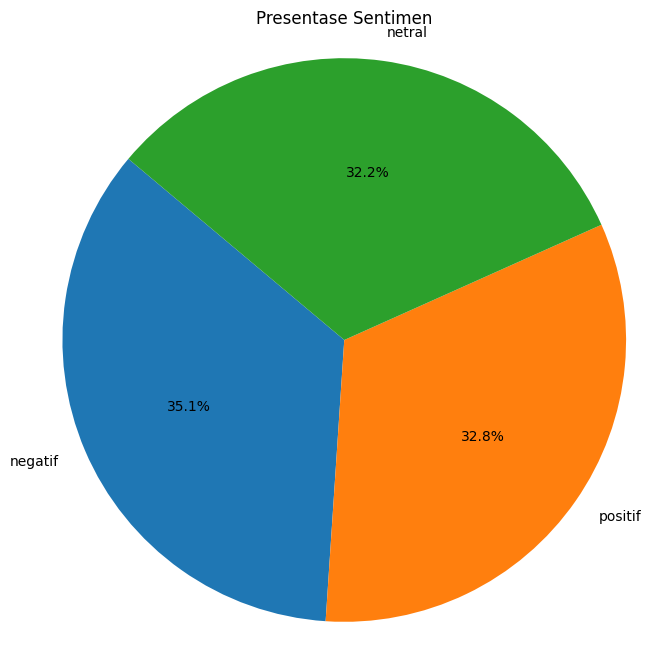

In [50]:
sentiment_counts = df['sentiment_predicted'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Presentase Sentimen')
plt.axis('equal')  
plt.show()

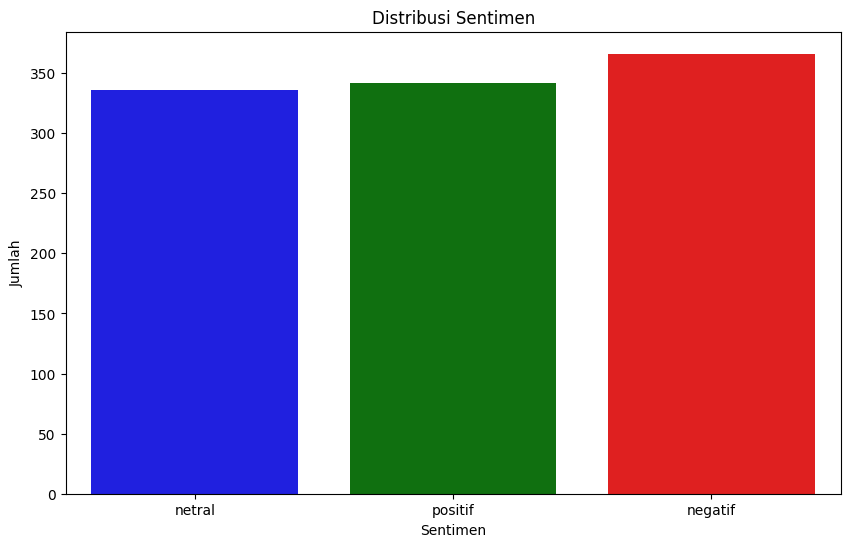

In [51]:
colors = {'netral': 'blue', 'positif': 'green', 'negatif': 'red'}

plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment_predicted', hue='sentiment_predicted', data=df, palette=colors)
plt.title('Distribusi Sentimen')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.show()

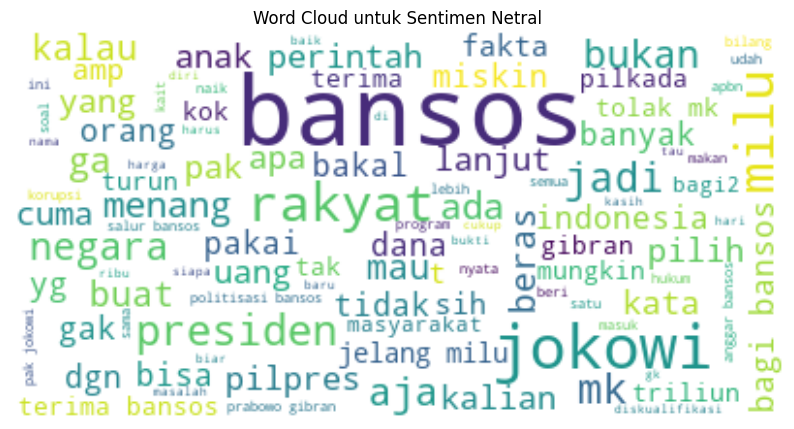

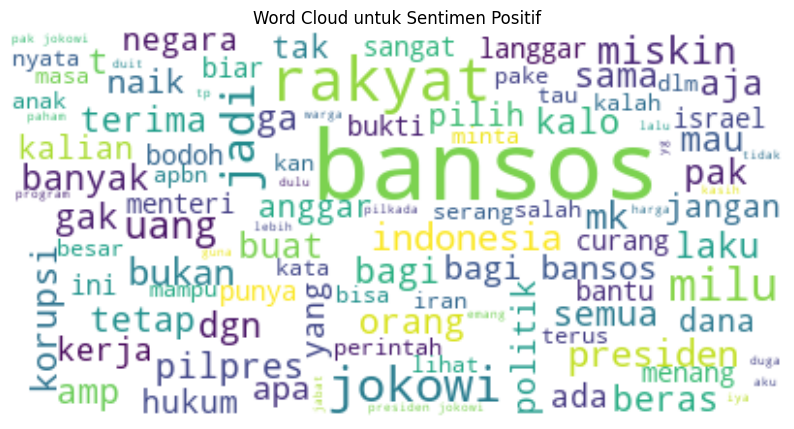

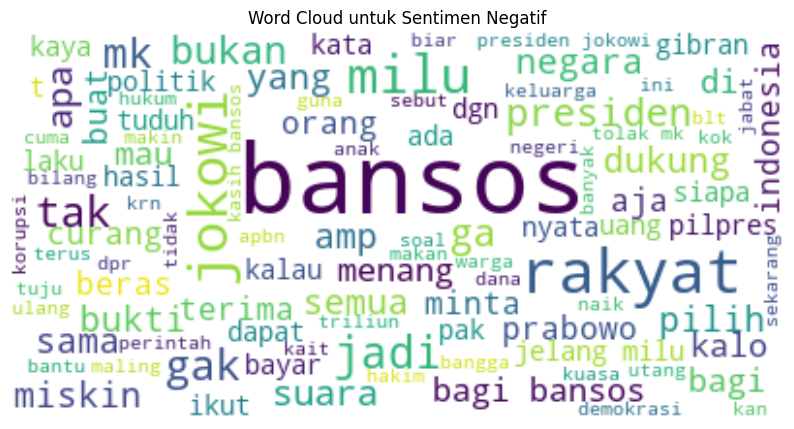

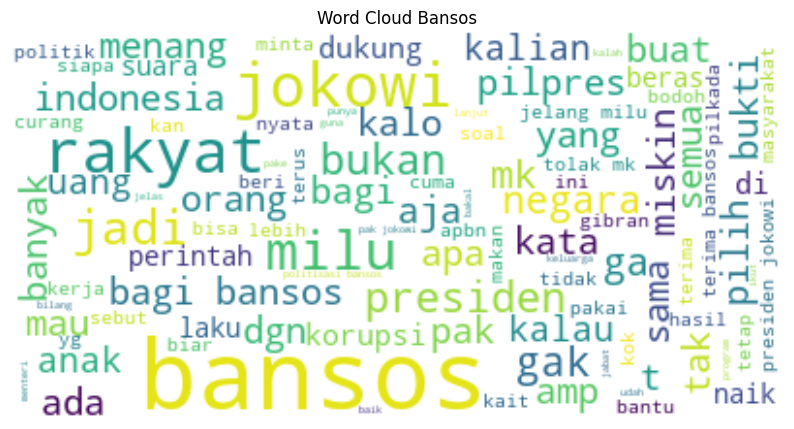

In [52]:
sentiments = df['sentiment_predicted'].unique()

for sentiment in sentiments:
    text = " ".join(review for review in df[df['sentiment_predicted'] == sentiment].full_text)
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud untuk Sentimen {sentiment.capitalize()}')
    plt.axis("off")
    plt.show()

all_text = ' '.join(df['full_text'])

wordcloud_all = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(all_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_all, interpolation='bilinear')
plt.title('Word Cloud Bansos')
plt.axis("off")
plt.show()

<Figure size 1000x600 with 0 Axes>

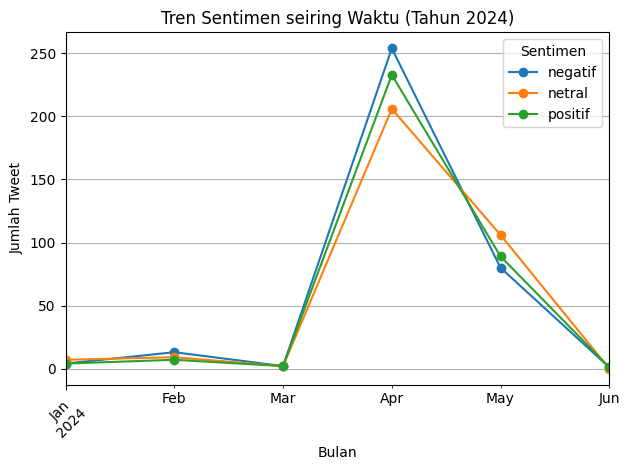

In [53]:
sentiment_counts_2024 = df_2024.groupby(['month', 'sentiment_predicted']).size().unstack(fill_value=0)

plt.figure(figsize=(10, 6))
sentiment_counts_2024.plot(kind='line', marker='o')
plt.title('Tren Sentimen seiring Waktu (Tahun 2024)')
plt.xlabel('Bulan')
plt.ylabel('Jumlah Tweet')
plt.xticks(rotation=45)
plt.legend(title='Sentimen')
plt.grid(True)
plt.tight_layout()
plt.show()